# Brain Tumor Detector

## Get and Load Dataset

In [1]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


In [2]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=30fc8656-b254-41c7-913a-41bb2a01d6bb
To: /content/brain_tumor.zip
100% 156M/156M [00:01<00:00, 80.8MB/s]


In [3]:
!unzip -q brain_tumor.zip

In [4]:
ls -l

total 152156
-rw-r--r-- 1 root root 155791278 Apr  5 02:30 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Jun 26 17:02 sample_data/
drwxr-xr-x 6 root root      4096 Jun 28 13:08 Testing/
drwxr-xr-x 6 root root      4096 Jun 28 13:08 Training/


In [5]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (464 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121925 files and directories currently install

In [6]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.15.0


## Utility functions to create dataset generators

### Perform image augmentation.

In [9]:
def augment(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    ## Random zoom and resize to original size
    #scales = list(np.arange(0.8, 1.2, 0.1))
    #scale = tf.random.shuffle(scales)[0]
    #new_height = tf.cast(scale * tf.cast(tf.shape(image)[0], tf.float32), tf.int32)
    #new_width = tf.cast(scale * tf.cast(tf.shape(image)[1], tf.float32), tf.int32)
    #image = tf.image.resize(image, [new_height, new_width])
    #image = tf.image.resize_with_crop_or_pad(image, tf.shape(image)[0], tf.shape(image)[1])

    # Adding Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label


In [10]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    # apply data augmentation to test data set
    train_ds = (train_ds
                .map(lambda image, label: augment(image, label), num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(2000)
                .prefetch(buffer_size=tf.data.AUTOTUNE))

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [11]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


## Plot some MRI scans with their corresponding classification labels:

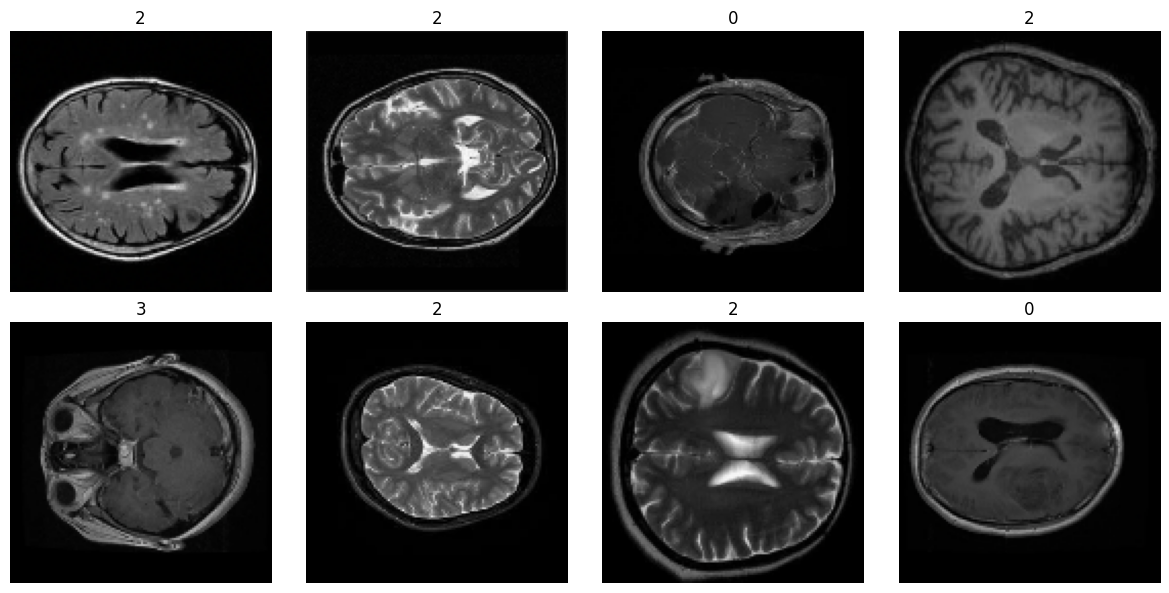

In [12]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

### Naive inspection of the data set:

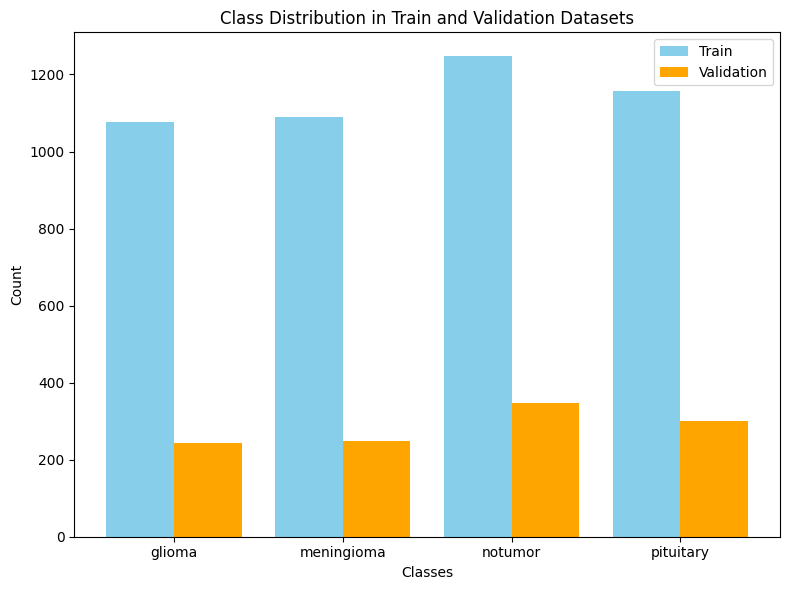

[1077, 1090, 1247, 1156]


In [13]:
def count_classes(dataset):
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}  # Assuming classes=['glioma', 'meningioma', 'notumor', 'pituitary']
    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[label] += 1
    return class_counts

# Count classes in train_ds and val_ds
train_class_counts = count_classes(train_ds)
val_class_counts = count_classes(val_ds)

# Prepare data for plotting
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
train_counts = [train_class_counts[i] for i in range(len(classes))]
val_counts = [val_class_counts[i] for i in range(len(classes))]
x = np.arange(len(classes))

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(x - 0.2, train_counts, width=0.4, label='Train', color='skyblue')
plt.bar(x + 0.2, val_counts, width=0.4, label='Validation', color='orange')

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution in Train and Validation Datasets')
plt.xticks(x, classes)
plt.legend()
plt.tight_layout()

plt.show()

print(train_counts)

### As we can see from the distribution plot there is some small imbalance. Balance the training data set.

In [14]:
# skip for now

## Build a naive CNN for baseline performance check:

*Make sure to normalize the data!*

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

num_classes = 4
img_height, img_width = 128, 128  # Adjust according to your image dimensions

# Define the model
model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Rescale pixel values to [0, 1]

    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [16]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
143/143 [==============================] - 26s 62ms/step - loss: 0.8895 - accuracy: 0.6219 - val_loss: 0.6416 - val_accuracy: 0.7487
Epoch 2/20
143/143 [==============================] - 17s 26ms/step - loss: 0.5798 - accuracy: 0.7788 - val_loss: 0.5162 - val_accuracy: 0.8047
Epoch 3/20
143/143 [==============================] - 15s 25ms/step - loss: 0.4607 - accuracy: 0.8212 - val_loss: 0.5856 - val_accuracy: 0.7898
Epoch 4/20
143/143 [==============================] - 15s 26ms/step - loss: 0.4162 - accuracy: 0.8514 - val_loss: 0.4697 - val_accuracy: 0.8161
Epoch 5/20
143/143 [==============================] - 16s 29ms/step - loss: 0.3634 - accuracy: 0.8597 - val_loss: 0.4457 - val_accuracy: 0.8345
Epoch 6/20
143/143 [==============================] - 14s 25ms/step - loss: 0.2908 - accuracy: 0.8928 - val_loss: 0.4202 - val_accuracy: 0.8450
Epoch 7/20
143/143 [==============================] - 13s 25ms/step - loss: 0.2720 - accuracy: 0.8985 - val_loss: 0.3951 - val_accuracy:

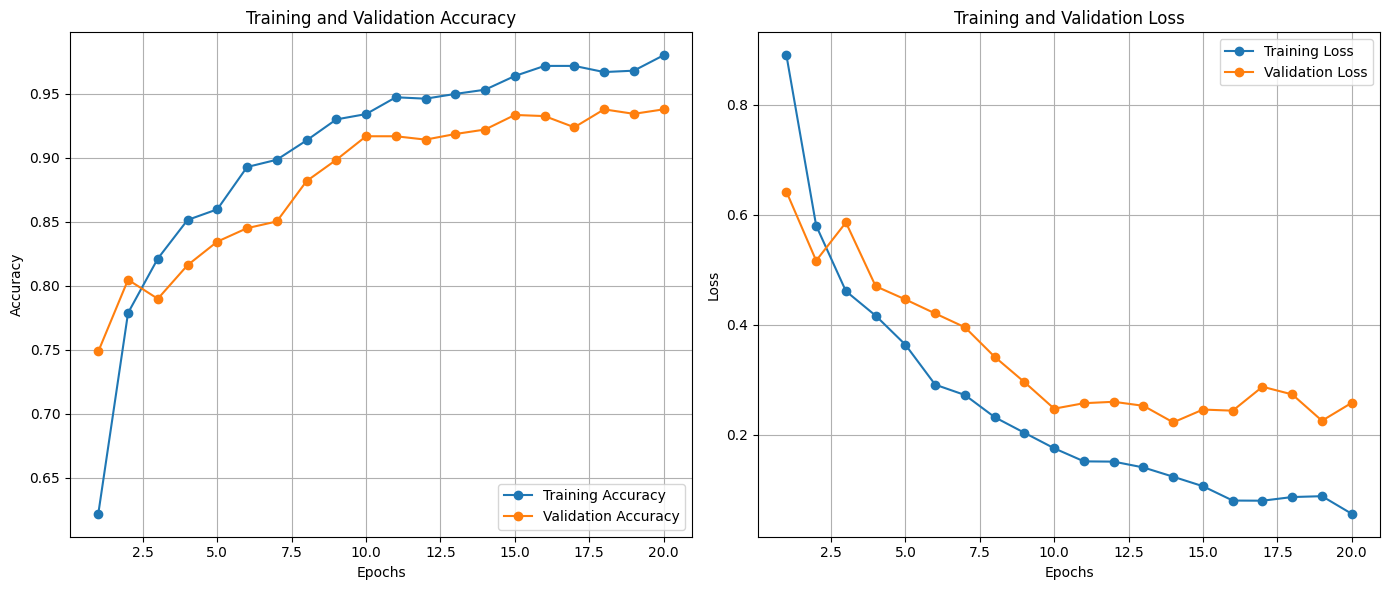

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)  # Adjust range to start from epoch 1

plt.figure(figsize=(14, 6))  # Increase figure width for better spacing

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  # Add grid lines
plt.legend(loc='lower right')  # Adjust legend position

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid lines
plt.legend(loc='upper right')  # Adjust legend position

plt.tight_layout()  # Improve subplot spacing
plt.show()

1/1 [==============================] - 0s 92ms/step


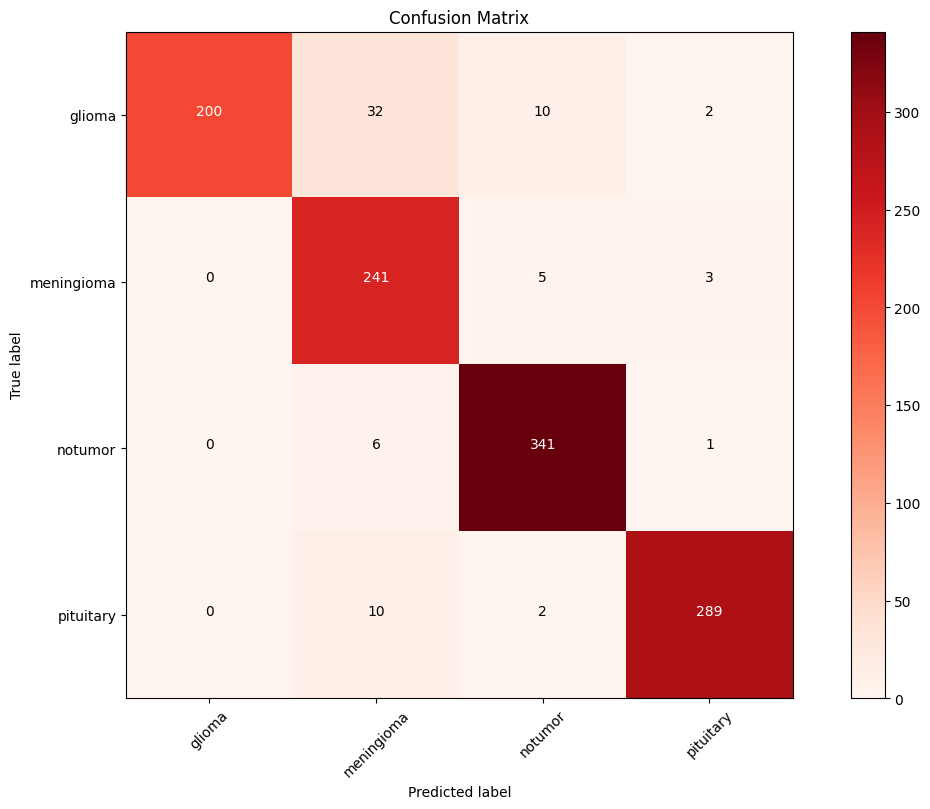

In [18]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming your model is trained and stored in a variable named 'model'
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Try with ResNet50 (fine tuning the top 5 layers according to our needs):

Also use tuning techniques such as dynamic learning rates, early stopping and dropout.

In [32]:
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50  # Import ResNet50 model

num_classes = 4
img_height, img_width = 128, 128  # Adjust according to your image dimensions
batch_size = 32

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers initially
base_model.trainable = False

# Find where to start unfreezing layers. The top layers are typically towards the end of the model.
# Let's say you want to unfreeze the top 5 convolutional blocks:
fine_tune_at = -5

# Unfreeze layers from fine_tune_at and onwards
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Build the model with dropout
model = tf.keras.Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Rescale pixel values to [0, 1]
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and dynamic learning rate
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Define callbacks: Early Stopping and Reduce Learning Rate on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

# Train the model
epochs = 30  # Increase epochs if needed
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                      

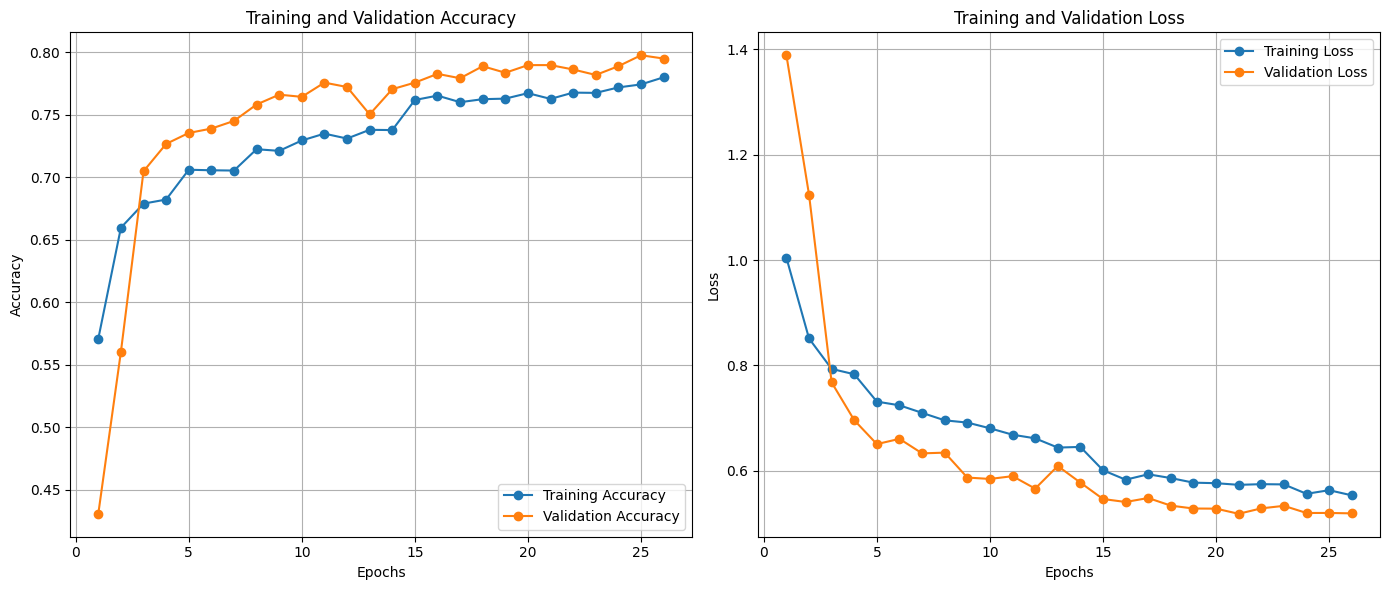

In [36]:
# Extract history metrics from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Determine the actual number of epochs based on the history length
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 891ms/step


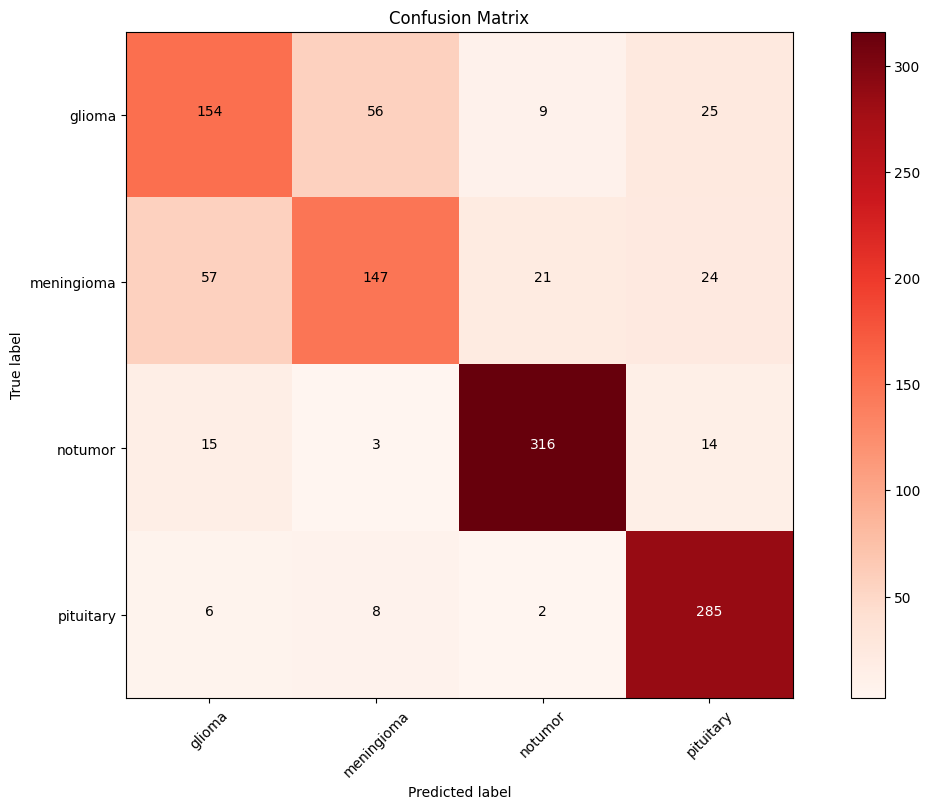

In [35]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming your model is trained and stored in a variable named 'model'
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Now do the same using EfficientNet:

In [29]:
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0  # Import EfficientNetB0 model

num_classes = 4
img_height, img_width = 128, 128  # Adjust according to your image dimensions
batch_size = 32

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze all layers initially
base_model.trainable = False

# Find where to start unfreezing layers. The top layers are typically towards the end of the model.
# Let's say you want to unfreeze the top 5 layers:
fine_tune_at = -5

# Unfreeze layers from fine_tune_at and onwards
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Build the model with dropout
model = tf.keras.Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Rescale pixel values to [0, 1]
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(num_classes, activation='softmax')
])

# Compile the model with Adam optimizer and dynamic learning rate
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Define callbacks: Early Stopping and Reduce Learning Rate on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

# Train the model
epochs = 20  # Increase epochs if needed
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)


16705208/16705208 [==============================] - 1s 0us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

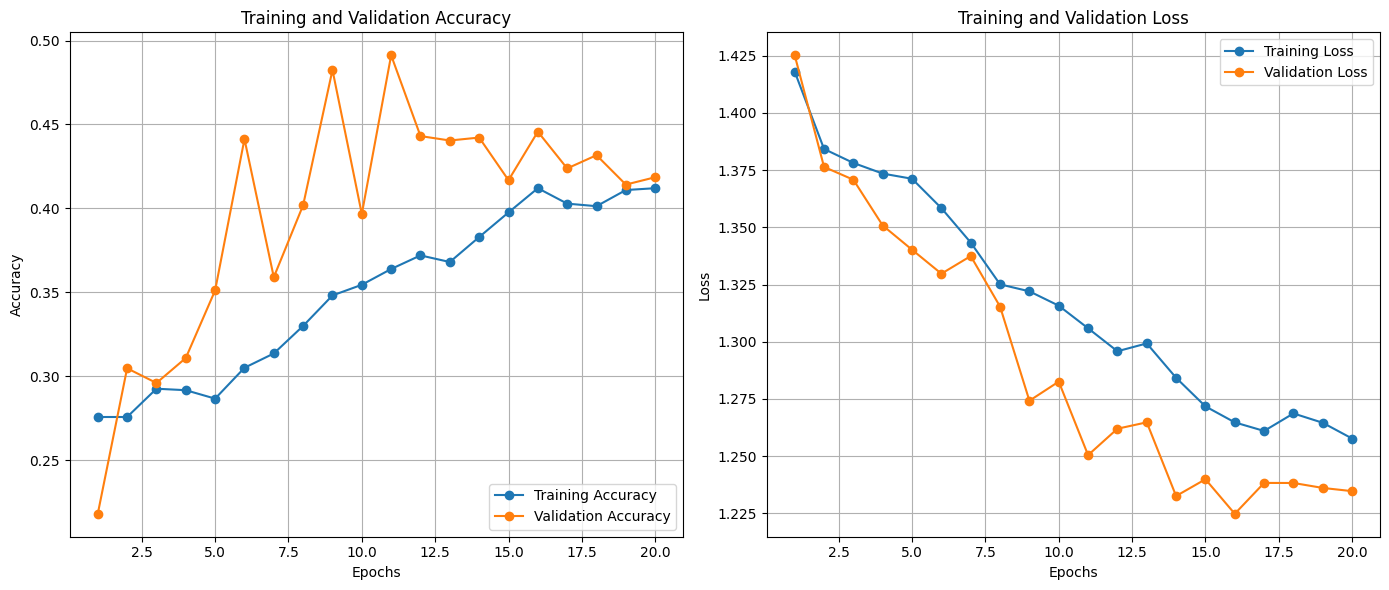

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)  # Adjust range to start from epoch 1

plt.figure(figsize=(14, 6))  # Increase figure width for better spacing

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  # Add grid lines
plt.legend(loc='lower right')  # Adjust legend position

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid lines
plt.legend(loc='upper right')  # Adjust legend position

plt.tight_layout()  # Improve subplot spacing
plt.show()

1/1 [==============================] - 1s 1s/step


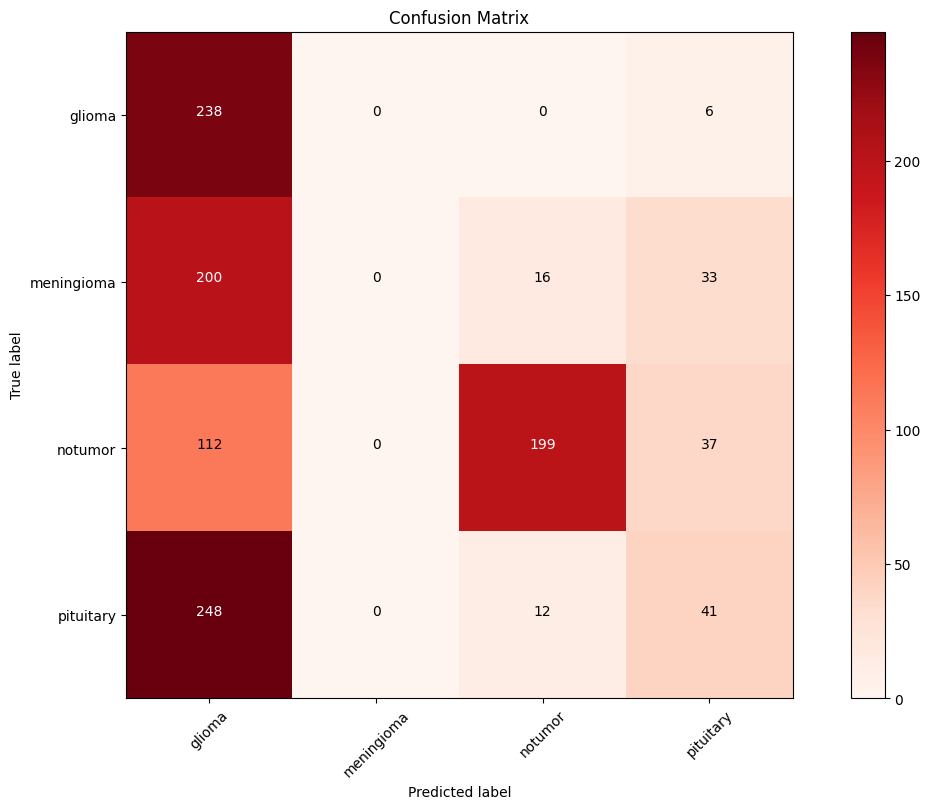

In [31]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming your model is trained and stored in a variable named 'model'
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we can see transfer learning using EfficientNet is poor.

### The naive baseline CNN model has a high accuracy. ResNet50 also seems to perform fine but seems to plateau starting at epoch 20 at around 77% accuracy. However, somewhat suprisingly EfficientNet has poor performance (<40% accuracy).

**Keep in mind:** We are working with medical images. Thus it is of utmost importance to **reduce the number of false negatives**. Therefore our metric of choice should be recall/sensitivity. We want to avoid that there is a tumor present but we classify it as no tumor.